## Environment Setup

In [1]:
import sys
import os

_path_added = False

def add_project_root_to_path():
    """
    Check if the project root directory is in the Python path.
    If not, add it to sys.path and change the working directory to the project root.
    """
    global _path_added

    if _path_added:
        return
    
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

    if root_dir not in sys.path:
        sys.path.append(root_dir)
    
    if os.getcwd() != root_dir:
        os.chdir(root_dir)
    _path_added = True


add_project_root_to_path()

### Import all needed libraries and establish a connection to the Database

In [4]:
import pandas as pd
import networkx as nx
import requests
from io import BytesIO
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from collections import Counter
from dorfterror_database.database_structure import Base, Post, Profile, Collaborator, Comment, Likes, Follower
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict
from datetime import datetime
import emoji
import re

root_path = Path(".").resolve()
db_path = root_path  / "dorfterror_database" / "dorfterror.db"

engine = create_engine(f"sqlite:///{db_path}")
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

Using database at: /home/nikl/programming/fhwd/web_social_media_analytics/dj-gpt/insta_scraping/dorfterror_database/dorfterror.db


## Visualizations

### Overview of Profile

#### Top Posts based on Follower-Like-Ratio

In [5]:
top_posts = session.query(
    Post.shortcode,
    Post.follower_like_ratio,
    Post.like_count,
    Post.comment_count,
    Post.caption
).order_by(Post.follower_like_ratio.desc()).limit(10).all()

df = pd.DataFrame(top_posts, columns=["Shortcode", "Follower Like Ratio", "Likes", "Comments", "Caption"])


df["Caption Preview"] = df["Caption"].fillna("").apply(lambda x: x[:100] + "..." if len(x) > 100 else x)

fig = px.bar(
    df,
    x="Shortcode",
    y="Follower Like Ratio",
    hover_data={
        "Shortcode": True,
        "Follower Like Ratio": True,
        "Likes": True,
        "Comments": True,
        "Caption Preview": True
    },
    title="Top 10 Posts by Follower Like Ratio",
    labels={"Shortcode": "Post", "Follower Like Ratio": "Follower Like Ratio"},
    color="Follower Like Ratio",
    color_continuous_scale="Agsunset"
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

#### Top Posts based on Likes

In [6]:
top_posts_likes = session.query(
    Post.shortcode,
    Post.like_count,
    Post.engagement_score_view,
    Post.comment_count,
    Post.caption
).order_by(Post.like_count.desc()).limit(10).all()

df = pd.DataFrame(top_posts_likes, columns=["Shortcode", "Likes", "Engagement Score", "Comments", "Caption"])

df["Caption Preview"] = df["Caption"].fillna("").apply(lambda x: x[:100] + "..." if len(x) > 100 else x)

fig = px.bar(
    df,
    x="Shortcode",
    y="Likes",
    hover_data={
        "Shortcode": True,
        "Likes": True,
        "Engagement Score": True,
        "Comments": True,
        "Caption Preview": True
    },
    title="Top 10 Posts by Likes (with Caption Preview)",
    labels={"Shortcode": "Post", "Likes": "Likes"},
    color="Likes",
    color_continuous_scale="Agsunset"
)

fig.show()

#### Top Posts based on Engagement Score

In [7]:
top_posts_engagement = session.query(
    Post.shortcode,
    Post.engagement_score_view,
    Post.like_count,
    Post.comment_count,
    Post.caption
).order_by(Post.engagement_score_view.desc()).limit(10).all()

df = pd.DataFrame(top_posts_engagement, columns=["Shortcode", "Engagement Score", "Likes", "Comments", "Caption"])

df["Caption Preview"] = df["Caption"].fillna("").apply(lambda x: x[:100] + "..." if len(x) > 100 else x)

fig = px.bar(
    df,
    x="Shortcode",
    y="Engagement Score",
    hover_data={
        "Shortcode": True,
        "Engagement Score": True,
        "Likes": True,
        "Comments": True,
        "Caption Preview": True
    },
    title="Top 10 by Engagement (with Caption-Preview)",
    labels={"Shortcode": "Post", "Engagement Score": "Engagement Score"},
    color="Engagement Score",
    color_continuous_scale="Agsunset"
)

fig.show()

#### Top Profiles who Like the most

In [8]:
likes = session.query(Likes).all()

like_counts = Counter([like.profile_id for like in likes if like.profile_id])

df_top_likers = pd.DataFrame(like_counts.items(), columns=['profile_id', 'like_count'])

profiles = session.query(Profile).all()
profile_map = {p.id: p.username for p in profiles}
df_top_likers['username'] = df_top_likers['profile_id'].map(profile_map)

df_top_likers = df_top_likers.sort_values('like_count', ascending=False).head(10)

fig = px.bar(
    df_top_likers,
    x='username',
    y='like_count',
    text='like_count',
    title='Top 10 Profiles That Liked the Most Posts',
    labels={'like_count': 'Number of Likes Given', 'username': 'Username'},
    color='like_count',
    color_continuous_scale='Agsunset'
)

max_likes = df_top_likers['like_count'].max()
fig.update_traces(textposition='outside')

fig.update_layout(
    yaxis=dict(range=[0, max_likes * 1.15]),  
    xaxis_tickangle=45,
    template='plotly_white',
    margin=dict(t=80),  
    yaxis_title='Likes Given',
    xaxis_title='Username'
)

fig.show()

### Time related Analytics

#### Average Likes per Weekday, seperated by year

In [9]:
posts = session.query(Post).all()
df_posts = pd.DataFrame([{
    'id': p.id,
    'date_local': p.date_local,
    'content_type': p.content_type,
    'like_count': p.like_count or 0,
    'comment_count': p.comment_count or 0,
    'caption_hashtags': p.caption_hashtags or [],
    'caption_mentions': p.caption_mentions or []
} for p in posts])

df_posts['year'] = df_posts['date_local'].dt.year
df_posts['weekday'] = df_posts['date_local'].dt.day_name()

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_posts['weekday'] = pd.Categorical(df_posts['weekday'], categories=ordered_days, ordered=True)

df_grouped = df_posts.groupby(['year', 'weekday'], observed=True)['like_count'].mean().reset_index()
df_grouped.rename(columns={'like_count': 'average_likes'}, inplace=True)

fig = px.bar(
    df_grouped,
    x='weekday',
    y='average_likes',
    color='year',
    barmode='group',
    title='Average Likes per Weekday, separated by Year',
    labels={'weekday': 'Weekday', 'year': 'Year', 'average_likes': 'Average Likes'},
    color_continuous_scale="Agsunset"
)

fig.update_layout(
    xaxis_tickangle=45,
    margin=dict(t=50, b=150)
)

fig.show()


#### Amount of Posts posted per hour of a day

In [10]:
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])

df_posts['year'] = df_posts['date_local'].dt.year
df_posts['hour'] = df_posts['date_local'].dt.hour

df_hourly_grouped = df_posts.groupby('hour', observed=True).size().reset_index(name='amount_posts')

all_hours = pd.DataFrame({'hour': list(range(24))})
df_hourly_grouped = all_hours.merge(df_hourly_grouped, on='hour', how='left')
df_hourly_grouped['amount_posts'] = df_hourly_grouped['amount_posts'].fillna(0).astype(int)

df_hourly_grouped['Time'] = df_hourly_grouped['hour'].apply(lambda h: f"{h:02d}:00 - {h+1:02d}:00")

df_hourly_grouped = df_hourly_grouped.sort_values(by='hour')

fig = px.bar(
    df_hourly_grouped,
    x='Time',
    y='amount_posts',
    title='Distribution of posts by time of day per year',
    labels={'amount_posts': 'Amount of Posts', 'Time': 'Time', 'year': 'Year'}
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(showgrid=True),
    margin=dict(t=50, b=150)
)

fig.show()


## Normalized Likes and Posts per Hour of Day

In [11]:
import plotly.graph_objects as go

df_hourly = df_posts.copy()

df_hourly['hour'] = df_hourly['date_local'].dt.hour
df_hourly['Time'] = df_hourly['hour'].apply(lambda h: f"{h:02d}:00 - {h+1:02d}:00")

df_hourly = df_hourly.groupby('Time').agg(
    amount_posts=('id', 'count'),
    amount_likes=('like_count', 'sum')
).reset_index()

total_posts = df_hourly['amount_posts'].sum()
total_likes = df_hourly['amount_likes'].sum()

df_hourly['posts_pct'] = df_hourly['amount_posts'] / total_posts * 100
df_hourly['likes_pct'] = df_hourly['amount_likes'] / total_likes * 100

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_hourly['Time'],
    y=df_hourly['posts_pct'],
    name='Posts (%)',
    marker_color='royalblue'
))

fig.add_trace(go.Bar(
    x=df_hourly['Time'],
    y=df_hourly['likes_pct'],
    name='Likes (%)',
    marker_color='orange'
))

fig.update_layout(
    barmode='group',
    title='Distribution of Posts and Likes by Time of Day (Relative %)',
    xaxis_title='Time',
    yaxis_title='Percentage (%)',
    xaxis_tickangle=-45,
    legend=dict(title='Metric'),
    template='plotly_white',
    margin=dict(t=50, b=150)
)

fig.show()


#### Cumulated Likes and Post Counts per Month over the time

In [12]:
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])
df_posts['month'] = df_posts['date_local'].dt.to_period('M')

df_monthly_likes = df_posts.groupby('month')['like_count'].sum().reset_index()
df_monthly_posts = df_posts.groupby('month').size().reset_index(name='post_count')

df_combined = pd.merge(df_monthly_likes, df_monthly_posts, on='month')
df_combined['month'] = df_combined['month'].astype(str)


fig = go.Figure()
# Like Count
fig.add_trace(go.Scatter(
    x=df_combined['month'],
    y=df_combined['like_count'],
    mode='lines+markers',
    name='Total Likes',
    yaxis='y1',
    line=dict(color='royalblue')
))
# Post Count
fig.add_trace(go.Scatter(
    x=df_combined['month'],
    y=df_combined['post_count'],
    mode='lines+markers',
    name='Post Count',
    yaxis='y2',
    line=dict(color='orange')
))

fig.update_layout(
    title='Cumulated Likes and Post Count Per Month',
    xaxis=dict(title='Month', tickangle=-45),
    yaxis=dict(
        title=dict(text='Total Likes', font=dict(color='royalblue')),
        tickfont=dict(color='royalblue')
    ),
    yaxis2=dict(
        title=dict(text='Post Count', font=dict(color='orange')),
        tickfont=dict(color='orange'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    margin=dict(t=60, b=100)
)

fig.show()


In [14]:
from plotly import graph_objects as go
import pandas as pd
from pathlib import Path

root_path = Path(".").resolve()

dorfterror_fe = pd.read_parquet(
    root_path / "insta_analytics_notebooks" / "dorfterror_feature_engineered.parquet"
)

dorfterror_fe['date_local'] = pd.to_datetime(dorfterror_fe['date_local'])
dorfterror_fe['month'] = dorfterror_fe['date_local'].dt.to_period('M')

df_monthly_likes = dorfterror_fe.groupby('month')['like_count'].sum().reset_index()
df_monthly_hashtags = dorfterror_fe.groupby('month')['number_of_caption_hashtags'].sum().reset_index()
df_monthly_posts = dorfterror_fe.groupby('month').size().reset_index(name='post_count')
df_combined = pd.merge(df_monthly_likes, df_monthly_hashtags, on='month')
df_combined = pd.merge(df_combined, df_monthly_posts, on='month')
df_combined['month'] = df_combined['month'].astype(str)


fig = go.Figure()
# Like Count
fig.add_trace(go.Scatter(
    x=df_combined['month'],
    y=df_combined['like_count'],
    mode='lines+markers',
    name='Total Likes',
    yaxis='y1',
    line=dict(color='royalblue')
))
# Post Count
fig.add_trace(go.Scatter(
    x=df_combined['month'],
    y=df_combined['number_of_caption_hashtags'],
    mode='lines+markers',
    name='Hashtag Count',
    yaxis='y2',
    line=dict(color='orange')
))

fig.update_layout(
    title='Cumulated Likes and Hashtag Count Per Month',
    xaxis=dict(title='Month', tickangle=-45),
    yaxis=dict(
        title=dict(text='Total Likes', font=dict(color='royalblue')),
        tickfont=dict(color='royalblue')
    ),
    yaxis2=dict(
        title=dict(text='Hashtag Count', font=dict(color='orange')),
        tickfont=dict(color='orange'),
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.01, y=0.99),
    template='plotly_white',
    margin=dict(t=60, b=100)
)

fig.show()

In [15]:
from plotly import graph_objects as go
import numpy as np

# Calculate average like count per post by month
monthly_avg_likes = df_monthly_likes.copy()
monthly_avg_likes = monthly_avg_likes.merge(df_monthly_posts, on='month')
monthly_avg_likes['like_count'] = monthly_avg_likes['like_count'] / monthly_avg_likes['post_count']

# Convert 'month' from Period to string for plotting
monthly_avg_likes['month'] = monthly_avg_likes['month'].astype(str)

# Calculate linear trend line
x = np.arange(len(monthly_avg_likes))
y = monthly_avg_likes['like_count'].values
coeffs = np.polyfit(x, y, 1)
trend = np.polyval(coeffs, x)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=monthly_avg_likes['month'],
    y=monthly_avg_likes['like_count'],
    mode='lines+markers',
    name='Average Like Count',
    line=dict(color='royalblue')
))
fig.add_trace(go.Scatter(
    x=monthly_avg_likes['month'],
    y=trend,
    mode='lines',
    name='Trend Line',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Average Like Count per Post by Month (with Trend Line)',
    xaxis=dict(title='Month', tickangle=-45),
    yaxis=dict(title='Average Like Count'),
    template='plotly_white',
    margin=dict(t=60, b=100)
)

fig.show()

In [32]:
from plotly import graph_objects as go
import numpy as np

import pandas as pd
from pathlib import Path

root_path = Path(".").resolve()

dorfterror_fe = pd.read_parquet(
    root_path / "insta_analytics_notebooks" / "dorfterror_feature_engineered.parquet"
)

temp_df = dorfterror_fe.copy()

temp_df['date_local'] = pd.to_datetime(temp_df['date_local'])
temp_df['month'] = temp_df['date_local'].dt.to_period('M')

# Calculate number of posts per month
monthly_post_counts = temp_df.groupby('month').size().reset_index(name='post_count')

# Calculate linear trend line for post counts
x = np.arange(len(monthly_post_counts))
y = monthly_post_counts['post_count'].values
coeffs = np.polyfit(x, y, 1)
trend = np.polyval(coeffs, x)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=monthly_post_counts['month'].astype(str),
    y=monthly_post_counts['post_count'],
    mode='lines+markers',
    name='Post Count',
    line=dict(color='royalblue')
))
fig.add_trace(go.Scatter(
    x=monthly_post_counts['month'].astype(str),
    y=trend,
    mode='lines',
    name='Trend Line',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Number of Posts per Month (with Trend Line)',
    xaxis=dict(title='Month', tickangle=-45),
    yaxis=dict(title='Number of Posts'),
    template='plotly_white',
    margin=dict(t=60, b=100)
)

fig.show()

In [25]:
# Extract year from 'date_local' and count posts per year
df_posts['year'] = df_posts['date_local'].dt.year
posts_per_year = df_posts.groupby('year').size().reset_index(name='post_count')

fig = px.bar(
    posts_per_year,
    x='year',
    y='post_count',
    title='Total Number of Posts per Year',
    labels={'year': 'Year', 'post_count': 'Number of Posts'},
    color='post_count',
    color_continuous_scale='Agsunset'
)

fig.update_layout(
    xaxis_tickformat='d',
    xaxis_title='Year',
    yaxis_title='Number of Posts',
    template='plotly_white'
)

fig.show()

In [16]:
# Calculate the average number of hashtags per post per year
avg_hashtags_per_year = dorfterror_fe.groupby('year')['number_of_caption_hashtags'].mean().reset_index(name='avg_hashtags_per_post')

fig = px.bar(
    avg_hashtags_per_year,
    x='year',
    y='avg_hashtags_per_post',
    labels={'year': 'Year', 'avg_hashtags_per_post': 'Average Hashtags per Post'},
    title='Average Number of Hashtags per Post per Year',
    color='avg_hashtags_per_post',
    color_continuous_scale='Agsunset'
)
fig.update_layout(xaxis_tickformat='d',template='plotly_white')
fig.show()


In [26]:
avg_likes_per_year = dorfterror_fe.groupby('year')['like_count'].mean().reset_index(name='avg_likes_per_post')

fig = px.bar(
    avg_likes_per_year,
    x='year',
    y='avg_likes_per_post',
    labels={'year': 'Year', 'avg_likes_per_post': 'Average Likes per Post'},
    title='Average Likes per Post per Year',
    color='avg_likes_per_post',
    color_continuous_scale='Agsunset'
)
fig.update_layout(xaxis_tickformat='d', template='plotly_white')
fig.show()

In [18]:
import plotly.express as px

fig = px.violin(
    df_posts,
    y='like_count',
    box=True,
    title='Distribution of Likes per Post',
    labels={'like_count': 'Likes per Post'},
    color_discrete_sequence=['#636EFA']
)
fig.update_layout(
    yaxis_title='Likes per Post',
    template='plotly_white',
    height=500,
    width=800
)
fig.show()

#### Like Development with all Posts since 2022

In [ ]:
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])

start_date = datetime(2022, 1, 1)
df_recent_posts = df_posts[df_posts['date_local'] >= start_date]

df_recent_posts_sorted = df_recent_posts.sort_values(by='date_local')

fig = px.scatter(
    df_recent_posts_sorted,
    x='date_local',
    y='like_count',
    title='Likes Timeline for Posts Since 2022',
    #markers=True,
    labels={'date_local': 'Post Date', 'like_count': 'Likes'}
)

fig.update_layout(
    xaxis_title='Post Date',
    yaxis_title='Like Count',
    xaxis_tickangle=-45,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


### Content Type Analytics

#### Distribution of Content Types

In [ ]:
content_counts = df_posts['content_type'].value_counts().reset_index()
content_counts.columns = ['Content Type', 'Amount']

fig = px.pie(
    content_counts,
    values='Amount',
    names='Content Type',
    title='Distribution of Content Types',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.show()


#### Likes per Content Type

In [ ]:
likes_by_format = df_posts.groupby('content_type')['like_count'].sum()
likes_pct = (likes_by_format / likes_by_format.sum()) * 100

df_likes_pct = likes_pct.reset_index()
df_likes_pct.columns = ['content_type', 'share']

fig = px.bar(
    df_likes_pct,
    x='content_type',
    y='share',
    title='Percentage Share of Likes per Content Type',
    labels={'share': 'Anteil (%)', 'content_type': 'Content-Format'},
    color='share',
    color_continuous_scale='Agsunset'
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(title='Share (%)'),
    xaxis=dict(title='Content Type'),
    coloraxis_colorbar=dict(title="Share (%)")
)

fig.show()

#### Comments per Content Type

In [ ]:
comments_by_format = df_posts.groupby('content_type')['comment_count'].sum()
comments_pct = (comments_by_format / comments_by_format.sum()) * 100

# DataFrame für Plotly
df_pct = comments_pct.reset_index()
df_pct.columns = ['content_type', 'share']

fig = px.bar(
    df_pct,
    x='content_type',
    y='share',
    title='Percentage Share of Comments per Content Type',
    labels={'share': 'Share (%)', 'content_type': 'Content Type'},
    color='share',
    color_continuous_scale='Agsunset'
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(title='Share (%)'),
    xaxis=dict(title='Content Type'),
    coloraxis_colorbar=dict(title="Share (%)")
)

fig.show()

#### Average Comment per Content Type

In [ ]:
avg_comments_format = df_posts.groupby('content_type')['comment_count'].mean().reset_index()

fig = px.bar(
    avg_comments_format,
    x='content_type',
    y='comment_count',
    color='comment_count',
    color_continuous_scale='Agsunset',
    labels={'content_type': 'Content Type', 'comment_count': 'average comments'},
    title='Avergage Comments per Content Type',
)

fig.update_layout(
    xaxis_tickangle=45,
    height=500,
    width=700
)

fig.show()



#### Average Likes per Content Type

In [ ]:
avg_likes_format = df_posts.groupby('content_type')['like_count'].mean().reset_index()

fig = px.bar(
    avg_likes_format,
    x='content_type',
    y='like_count',
    color='like_count',
    color_continuous_scale='Agsunset',
    labels={'content_type': 'Content Type', 'like_count': 'average likes'},
    title='Average Likes per Content Type',
)

fig.update_layout(
    xaxis_tickangle=45,
    height=500,
    width=700
)

fig.show()



In [39]:
# Load the posts table from the SQLite database into a DataFrame using pandas
posts_df = pd.read_sql_table('posts', con=engine)
posts_df.head()

,id,shortcode,user_posted,date_local,url,content_type,caption,caption_hashtags,caption_mentions,tagged_users,...,thumbnail,product_type,coauthor_producers,engagement_score_view,is_collab,total_follower_reach,category,follower_like_count,follower_like_ratio,follower_to_non_follower_ratio
0,3594661922130178427,DHizfkMMTF7,dorfterror,2025-03-23 13:38:35,https://www.instagram.com/p/DHizfkMMTF7,Carousel,"Kölle, dao bis asozial! \n\nTausend Dank an eu...","[#dorfterror, #nofuturekid, #köln]","[minohband, muellem_mon_amour.161, castell_cgn...","[{'full_name': 'Castell Köln', 'id': '55583926...",...,https://instagram.fagc3-2.fna.fbcdn.net/v/t51....,None,None,NaN,False,4204,Live & Tour,184,0.043768,0.943590
1,3593194961890418901,DHdl8fAM6DV,dorfterror,2025-03-21 13:04:00,https://www.instagram.com/p/DHdl8fAM6DV,Carousel,Was geht denn jetzt ab??! 🤩\n\nWir sind dieses...,None,[riez_openair],"[{'full_name': 'Crystal Lake「Official」', 'id':...",...,https://scontent-ord5-3.cdninstagram.com/v/t51...,None,None,NaN,False,4204,Live & Tour,117,0.027831,0.906977
2,3593127681118629159,DHdWpa5su0n,muellem_mon_amour.161,2025-03-21 10:55:42,https://www.instagram.com/reel/DHdWpa5su0n,Video,@minohband \n@dorfterror \n@castell\nRegentens...,None,"[minohband, dorfterror, castell]","[{'full_name': 'Castell Köln', 'id': '55583926...",...,https://scontent-iad3-1.cdninstagram.com/v/t51...,clips,"[mister_no_limit, dorfterror]",427.0,True,6429,Live & Tour,31,0.007374,0.607843
3,3593092335576265870,DHdOnEzM7SO,dorfterror,2025-03-21 09:40:06,https://www.instagram.com/p/DHdOnEzM7SO,Carousel,Klingeling! Heute Abend spielen wir in #köln u...,"[#köln, #punkrock, #keinbockaufnazis, #dorfter...","[minohband, castell_cgn, nikl_nkl, wild_n_free...","[{'full_name': 'Castell Köln', 'id': '55583926...",...,https://scontent-atl3-1.cdninstagram.com/v/t51...,None,"[castell_cgn, minohband]",NaN,True,11451,Live & Tour,105,0.024976,0.826772
4,3591148393389518556,DHWUm_jsm7c,dorfterror,2025-03-18 17:17:50,https://www.instagram.com/p/DHWUm_jsm7c,Image,Am Samstag geht es für uns nach Klein Ammensle...,[#scheune],"[von.hoelle.band, the_jeals, gmx.de]","[{'full_name': 'The JEALS', 'id': '7273731243'...",...,https://scontent-lga3-2.cdninstagram.com/v/t51...,None,[von.hoelle.band],NaN,True,4631,Live & Tour,56,0.013321,0.736842


In [44]:
fig = px.pie(
    posts_df,
    names='category',
    title='Distribution of Posts by Content Type',
    color_discrete_sequence=px.colors.qualitative.Pastel
)
fig.update_traces(textinfo='percent+label')
fig.update_layout(height=500, width=800)
fig.show()

In [48]:
avg_likes_per_category = posts_df.groupby('category')['like_count'].mean().reset_index(name='avg_likes')

fig = px.bar(
    avg_likes_per_category,
    x='category',
    y='avg_likes',
    color='avg_likes',
    color_continuous_scale='Agsunset',
    title='Average Likes per Category',
    labels={'category': 'Category', 'avg_likes': 'Average Likes'}
)
fig.update_layout(
    xaxis_tickangle=45,
    template='plotly_white',
    height=500,
    width=800
)

fig.show()

In [81]:
# Count the number of posts for each (category, content_type) combination
category_content_counts = posts_df.groupby(['category', 'content_type']).size().reset_index(name='count')

# Create a grouped bar plot
fig = px.bar(
    category_content_counts,
    x='category',
    y='count',
    color='content_type',
    barmode='group',
    title='Number of Posts per Content Type in Each Category',
    labels={'count': 'Number of Posts', 'category': 'Category', 'content_type': 'Content Type'},
    color_discrete_sequence=px.colors.qualitative.Pastel
)

# Set the order of content types
content_type_order = ['Carousel', 'Image',  'Reel', 'Video']
fig.update_xaxes(categoryorder='array', categoryarray=sorted(category_content_counts['category'].unique()))
fig.update_traces(
    selector=dict(type='bar'),
    marker_line_width=1
)
fig.for_each_trace(
    lambda t: t.update(
        legendgroup=t.name,
        legendgrouptitle_text=None
    )
)
fig.update_layout(
    legend_traceorder="reversed"
)
# Reorder the legend and bars by content_type_order
fig.data = tuple(sorted(fig.data, key=lambda t: content_type_order.index(t.name) if t.name in content_type_order else 99))

fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Number of Posts',
    xaxis_tickangle=-45,
    template='plotly_white',
    height=500,
    width=800
)

fig.show()

In [74]:
# Filter posts with content_type 'Video' or 'Reel'
video_posts = posts_df[posts_df['content_type'].str.lower().isin(['video', 'reel'])].copy()

# Ensure video_duration and like_count are numeric
video_posts['video_duration'] = pd.to_numeric(video_posts['video_duration'], errors='coerce')
video_posts['like_count'] = pd.to_numeric(video_posts['like_count'], errors='coerce')

# Drop rows with missing duration or likes
video_posts = video_posts.dropna(subset=['video_duration', 'like_count'])

# Plot: Likes vs Video Duration (seconds)
fig = px.scatter(
    video_posts,
    x='video_duration',
    y='like_count',
    title='Distribution of Likes vs Video Length for Videos/Reels',
    labels={'video_duration': 'Video Length (seconds)', 'like_count': 'Likes'},
    hover_data=['shortcode', 'caption'],
)
fig.update_layout(template='plotly_white', height=500,
    width=800)
fig.show()

In [ ]:
import plotly.express as px

followers_df = pd.read_sql_query("SELECT * FROM followers", con=engine)


fig_likes = px.violin(
    followers_df,
    y='likes_count',
    box=True,
    color_discrete_sequence=['royalblue'],
    title='Distribution of Likes per Follower'
)
fig_likes.update_layout(
    yaxis_title='Likes per Follower',
    template='plotly_white',
    height=400,
    width=600
)

fig_comments = px.violin(
    followers_df,
    y='comment_count',
    box=True,
    color_discrete_sequence=['orange'],
    title='Distribution of Comments per Follower'
)
fig_comments.update_layout(
    yaxis_title='Comments per Follower',
    template='plotly_white',
    height=400,
    width=600
)

fig_likes.show()
fig_comments.show()
fig.show()

### Top used Hashtags in Posts

In [ ]:
all_hashtags = [hashtag.lower() for hashtags in df_posts['caption_hashtags'] for hashtag in (hashtags if hashtags else [])]
top_hashtags = Counter(all_hashtags).most_common(20)
hashtags, counts = zip(*top_hashtags)

# DataFrame für Plotly vorbereiten
df_hashtags = pd.DataFrame({
    'Hashtag': hashtags,
    'Anzahl': counts
})

# Plotly Balkendiagramm horizontal
fig = px.bar(
    df_hashtags,
    x='Anzahl',
    y='Hashtag',
    orientation='h',
    color='Anzahl',
    color_continuous_scale='Agsunset',
    title='Top 20 most common Hashtags',
    labels={'Anzahl': 'Amount', 'Hashtag': 'Hashtag'}
)

# Zeige alle Hashtag-Namen auf der y-Achse
fig.update_yaxes(tickmode='array', tickvals=df_hashtags['Hashtag'], ticktext=df_hashtags['Hashtag'])

# Sortierung y-Achse (Top von oben)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()


### Interactions with other Profiles

#### Network Graph for Collaborators

##### Plotly version

In [ ]:
dorfterror_profile = session.query(Profile).filter(Profile.username == 'dorfterror').first()

dorfterror_post_ids = [
    p.id for p in session.query(Post).filter(Post.user_posted == dorfterror_profile.username)
]

collabs = session.query(Collaborator).filter(Collaborator.post_id.in_(dorfterror_post_ids)).all()

collab_counts = Counter([c.profile_id for c in collabs])

collab_profiles = session.query(Profile).filter(Profile.id.in_(list(collab_counts.keys()))).all()
id_to_profile = {p.id: p for p in collab_profiles}

G = nx.Graph()
G.add_node(dorfterror_profile.username, size=1000, image_url=dorfterror_profile.profile_image_link)

for collab_id, count in collab_counts.items():
    profile = id_to_profile.get(collab_id)
    if profile:
        G.add_node(profile.username, size=300 + count * 100, image_url=profile.profile_image_link)
        G.add_edge(dorfterror_profile.username, profile.username)


# Layout mit mehr Platz
#pos = nx.spring_layout(G, k=1.2, seed=42)

import numpy as np

def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def resolve_overlaps(pos, sizes, min_dist_factor=1.2, max_iter=200):
    """
    Verschiebt Knoten, falls sie sich basierend auf ihrer Bildgröße überlappen.
    """
    for _ in range(max_iter):
        moved = False
        for n1 in pos:
            for n2 in pos:
                if n1 == n2:
                    continue
                p1, p2 = np.array(pos[n1]), np.array(pos[n2])
                dist = get_distance(p1, p2)
                min_dist = (sizes[n1] + sizes[n2]) * min_dist_factor / 20  

                if dist < min_dist:
                    direction = (p1 - p2) / (dist + 1e-5)
                    shift = (min_dist - dist) / 2
                    pos[n1] = tuple(p1 + direction * shift)
                    pos[n2] = tuple(p2 - direction * shift)
                    moved = True
        if not moved:
            break
    return pos


center_node = dorfterror_profile.username
other_nodes = [n for n in G.nodes if n != center_node]

num_nodes = len(other_nodes)
angle_step = 2 * np.pi / max(num_nodes, 1)

max_size = max(G.nodes[n]["size"] for n in other_nodes) if other_nodes else 1

pos_plotly = {center_node: (0, 0)}
for i, node in enumerate(sorted(other_nodes)):
    angle = i * angle_step
    size = G.nodes[node]["size"]
    radius = 2 + 4 * (size / max_size)
    x = np.cos(angle) * radius
    y = np.sin(angle) * radius
    pos_plotly[node] = (x, y)

edge_x = []
edge_y = []
for edge in G.edges:
    x0, y0 = pos_plotly[edge[0]]
    x1, y1 = pos_plotly[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_size = []
node_text = []

for node in G.nodes:
    x, y = pos_plotly[node]
    node_x.append(x)
    node_y.append(y)
    node_size.append(G.nodes[node]["size"] / 15 + 20)  
    if node == center_node:
        hovertext = f"{node} (Zentrum)"
    else:
        profile_id = None
        for pid, prof in id_to_profile.items():
            if prof.username == node:
                profile_id = pid
                break
        count = collab_counts.get(profile_id, 0) if profile_id else 0
        hovertext = f"{node}<br>Kollaborationen: {count}"
    node_text.append(hovertext)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[center_node if node == center_node else "" for node in G.nodes],
    textposition="bottom center",
    marker=dict(
        showscale=False,
        color='lightblue',
        size=node_size,
        line_width=2,
        line_color='black',
    ),
    textfont=dict(size=12),
    hovertext=node_text
)

images = []
for node in G.nodes:
    x, y = pos_plotly[node]
    size_px = node_size[list(G.nodes).index(node)] * 3 

    img_url = G.nodes[node].get('image_url') or "https://via.placeholder.com/150"

    images.append(dict(
        source=img_url,
        xref="x", yref="y",
        x=x - 0.1, y=y + 0.1,
        sizex=0.2, sizey=0.2,
        xanchor="center",
        yanchor="middle",
        layer="above",
        sizing="contain",
        opacity=1
    ))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Collaborators of Dorfterror",
                    title_x=0.5,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-6,6]),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-6,6]),
                    images=images
                ))

fig.show()

##### Previous Matplotlib version

Fehler bei dorfterror: 403 Client Error: Forbidden for url: https://scontent-cdg4-2.cdninstagram.com/v/t51.2885-19/468566340_1080483403382431_3800128179714413222_n.jpg?stp=dst-jpg_s320x320_tt6&_nc_ht=scontent-cdg4-2.cdninstagram.com&_nc_cat=107&_nc_oc=Q6cZ2QFMtMF9zvB5aECEDFIfajeSOdMxUHq0yUwvOmNfYOK4wKUQZhe8WiFCR8wg6eJHHgI&_nc_ohc=cl_x3tc0wvgQ7kNvwH6iRrq&_nc_gid=ptLv-dxArep7DJ6QsyiUdA&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AfRtmoUvuBlid_D_dP8QtIY88V6xwYBt1Ckz2tPl6nJk1g&oe=68746D70&_nc_sid=8b3546
Fehler bei muselkanner: 403 Client Error: Forbidden for url: https://scontent-gig4-2.cdninstagram.com/v/t51.2885-19/52699500_1006762016200981_3772279542832431104_n.jpg?stp=dst-jpg_s320x320_tt6&_nc_ht=scontent-gig4-2.cdninstagram.com&_nc_cat=101&_nc_oc=Q6cZ2QFtp2oBggFeBQX_FSri0TnODLJywWuzkqwpjKNY8nn_0_Waco0nZC-w3BusWQ6nSMM&_nc_ohc=OXjDD6xFYAAQ7kNvwEqlU5l&_nc_gid=ebotPhv00L9iLEPWaUOnMQ&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AfRY03jgxwiVFX8FLe6rh7bPH924N_k3A98n5tAofsmWdQ&oe=687831C8&_nc_sid=8b3546
Fehler bei alter

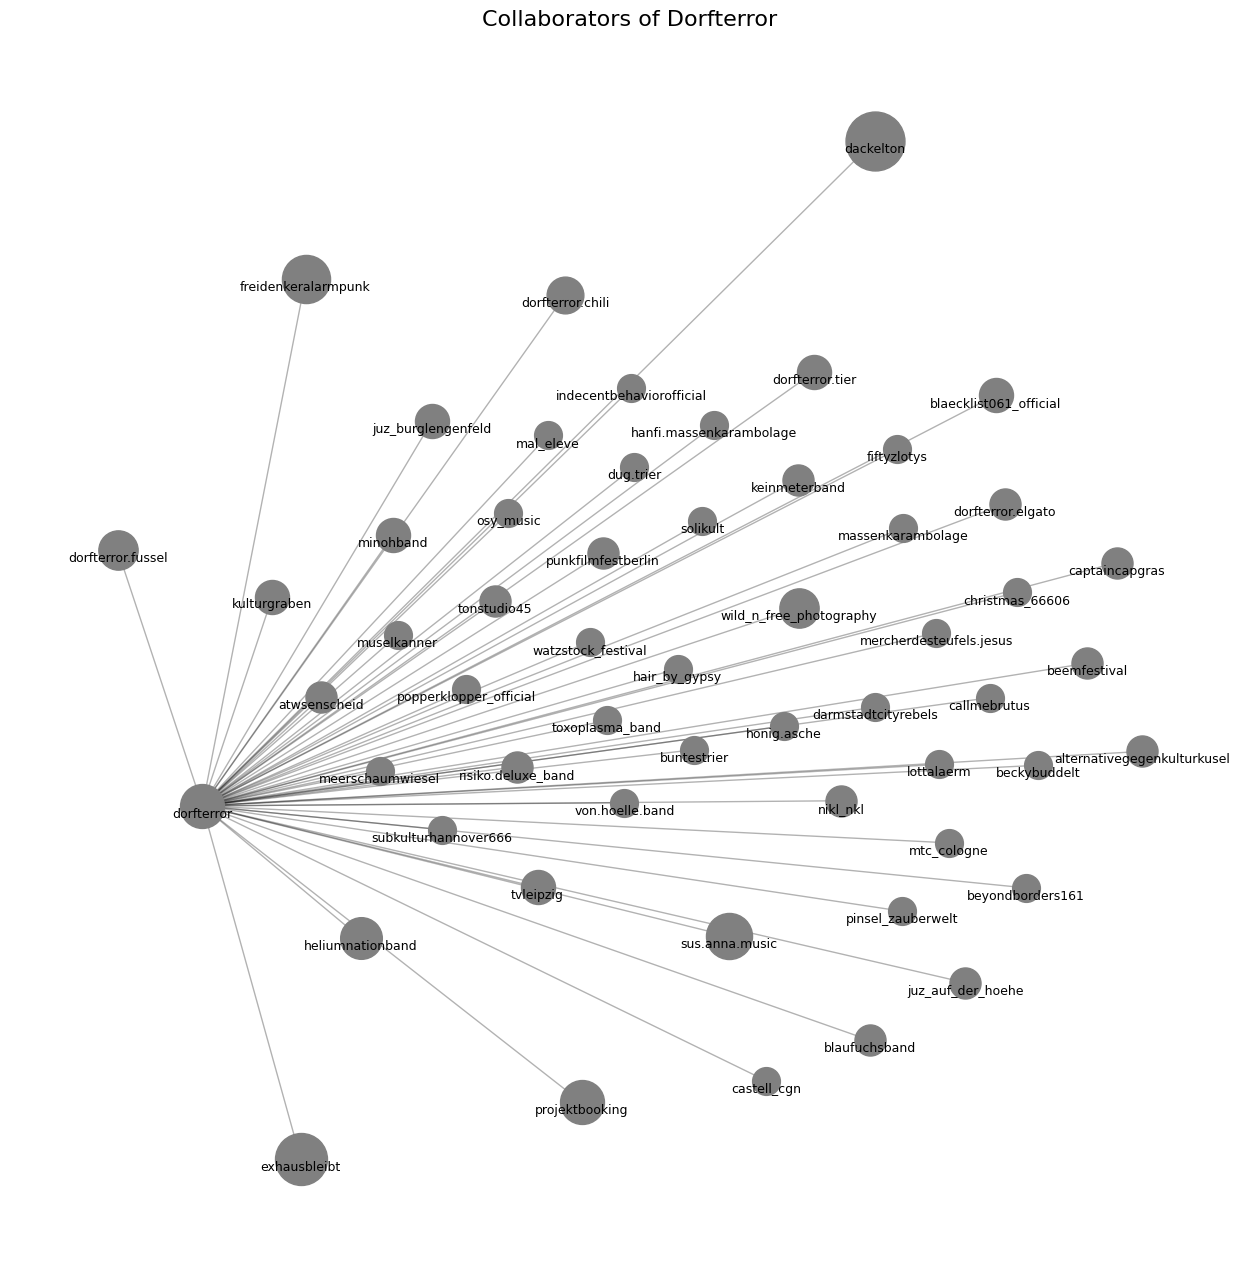

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np
from PIL import Image, ImageDraw

dorfterror_profile = session.query(Profile).filter(Profile.username == 'dorfterror').first()

dorfterror_post_ids = [
    p.id for p in session.query(Post).filter(Post.user_posted == dorfterror_profile.username)
]

collabs = session.query(Collaborator).filter(Collaborator.post_id.in_(dorfterror_post_ids)).all()

collab_counts = Counter([c.profile_id for c in collabs])

collab_profiles = session.query(Profile).filter(Profile.id.in_(list(collab_counts.keys()))).all()
id_to_profile = {p.id: p for p in collab_profiles}

G = nx.Graph()
G.add_node(dorfterror_profile.username, size=1000, image_url=dorfterror_profile.profile_image_link)

for collab_id, count in collab_counts.items():
    profile = id_to_profile.get(collab_id)
    if profile:
        G.add_node(profile.username, size=300 + count * 100, image_url=profile.profile_image_link)
        G.add_edge(dorfterror_profile.username, profile.username)


# Layout mit mehr Platz
#pos = nx.spring_layout(G, k=1.2, seed=42)

import numpy as np

def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def resolve_overlaps(pos, sizes, min_dist_factor=1.2, max_iter=200):
    """
    Verschiebt Knoten, falls sie sich basierend auf ihrer Bildgröße überlappen.
    """
    for _ in range(max_iter):
        moved = False
        for n1 in pos:
            for n2 in pos:
                if n1 == n2:
                    continue
                p1, p2 = np.array(pos[n1]), np.array(pos[n2])
                dist = get_distance(p1, p2)
                min_dist = (sizes[n1] + sizes[n2]) * min_dist_factor / 20  

                if dist < min_dist:
                    direction = (p1 - p2) / (dist + 1e-5)
                    shift = (min_dist - dist) / 2
                    pos[n1] = tuple(p1 + direction * shift)
                    pos[n2] = tuple(p2 - direction * shift)
                    moved = True
        if not moved:
            break
    return pos

center_node = dorfterror_profile.username
pos = {center_node: (0, 0)}

other_nodes = [n for n in G.nodes if n != center_node]
num_nodes = len(other_nodes)
angle_step = 2 * np.pi / num_nodes

max_size = max(G.nodes[n]["size"] for n in other_nodes)
sizes = {n: G.nodes[n]["size"] / 10 for n in G.nodes} 

for i, node in enumerate(sorted(other_nodes)):
    angle = i * angle_step
    size = G.nodes[node]["size"]
    radius = 2 + 4 * (size / max_size)
    x = np.cos(angle) * radius
    y = np.sin(angle) * radius
    pos[node] = (x, y)

pos = resolve_overlaps(pos, sizes)



plt.figure(figsize=(16, 16))
ax = plt.gca()
nx.draw_networkx_edges(G, pos, alpha=0.3)

for node in G.nodes:
    x, y = pos[node]
    node_size = G.nodes[node]['size']
    img_url = G.nodes[node].get('image_url') or "https://via.placeholder.com/150"

    try:
        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(img_url, headers=headers, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        size = int(node_size / 10)
        img = img.resize((size, size), Image.LANCZOS)

        mask = Image.new('L', (size, size), 0)
        draw_mask = ImageDraw.Draw(mask)
        draw_mask.ellipse((0, 0, size, size), fill=255)

        border_size = 2  
        bordered_img = Image.new("RGBA", (size + 2 * border_size, size + 2 * border_size), (0, 0, 0, 0))
        border_draw = ImageDraw.Draw(bordered_img)
        border_draw.ellipse(
            (0, 0, size + 2 * border_size, size + 2 * border_size),
            fill=(0, 0, 0, 255)  
        )

        img.putalpha(mask)
        bordered_img.paste(img, (border_size, border_size), img)

        img_box = OffsetImage(bordered_img, zoom=1)
        ab = AnnotationBbox(img_box, (x, y), frameon=False)
        ax.add_artist(ab)

        fig = plt.gcf()
        ax = plt.gca()
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        ax_width, ax_height = bbox.width, bbox.height

        scale = ax.transData.inverted().transform([(0, 0), (0, size)])
        dy = abs(scale[1][1] - scale[0][1])

        plt.text(x, y - dy / 2 - 1, node, ha='center', va='top', fontsize=9)


    except Exception as e:
        print(f"Fehler bei {node}: {e}")
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=node_size, node_color='gray', ax=ax)
        plt.text(x, y - 0.1, node, ha='center', va='top', fontsize=9)


plt.title('Collaborators of Dorfterror', fontsize=16)
plt.axis('off')
plt.show()

#### Top tagged profiles

In [ ]:
mentions = [mention.lower() for mentions_list in df_posts['caption_mentions'] for mention in (mentions_list if mentions_list else [])]
from collections import Counter
top_mentions = Counter(mentions).most_common(20)
mention_names, mention_counts = zip(*top_mentions)

df_mentions = pd.DataFrame({
    'Profil': mention_names,
    'Anzahl': mention_counts
})

fig = px.bar(
    df_mentions,
    x='Anzahl',
    y='Profil',
    orientation='h',
    color='Anzahl',
    color_continuous_scale='Agsunset',
    title='Top 20 most tagged Profiles',
    labels={'Anzahl': 'Amount', 'Profil': 'Profile'}
)

fig.update_layout(yaxis={'categoryorder':'total ascending'}, 
                  margin=dict(l=120), 
                  height=600)
fig.show()

### Comment Analytics

#### Distribution of Comment length; Wort zu Emoji Verhältnis; Count für nur emoji kommentare vs andere

In [ ]:
comments = session.query(Comment).filter(Comment.text != None).all()
df_comments = pd.DataFrame([{
    'text_length': len(c.text),
    'post_id': c.post_id
} for c in comments])

hist_data = df_comments['text_length']
avg_comment_length = hist_data.mean()

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=hist_data,
    nbinsx=30,
    name='Kommentar-Längen',
    marker=dict(
        color='limegreen',
        line=dict(color='black', width=1)
    ),
    opacity=0.75
))

fig.add_trace(go.Scatter(
    x=[avg_comment_length, avg_comment_length],
    y=[0, hist_data.value_counts().max() * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f'Durchschnitt: {avg_comment_length:.1f} Zeichen'
))

fig.update_layout(
    title=f'Distribution comment length: {avg_comment_length:.1f} characters',
    xaxis_title='Length of Comment (characters)',
    yaxis_title='Amount comments',
    bargap=0.1,
    width=700,
    height=450
)

fig.show()


#### Percentage of Emojis and Text in Comments

In [ ]:
df_comments_emoji = pd.DataFrame([{
    'word_count': len(re.findall(r'\b\w+\b', c.text)),
    'emoji_count': sum(1 for char in c.text if char in emoji.EMOJI_DATA)
} for c in comments])

total_words = df_comments_emoji['word_count'].sum()
total_emojis = df_comments_emoji['emoji_count'].sum()

data = pd.DataFrame({
    'Type': ['Words', 'Emojis'],
    'Count': [total_words, total_emojis]
})

fig = px.pie(
    data,
    names='Type',
    values='Count',
    title='Relative Share of Words vs Emojis in All Comments',
    color_discrete_map={'Words': 'lightblue', 'Emojis': 'orange'}
)

fig.update_traces(textinfo='percent+label')
fig.show()

#### Percentage of Emoji-only, Text-only and Mixed Comments

In [ ]:
def contains_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in text)

def is_emoji_only(text):
    text = text.strip()
    return all(char in emoji.EMOJI_DATA or char.isspace() for char in text) and text != ""

def is_text_only(text):
    return not contains_emoji(text)

df_comments_only_emoji = pd.DataFrame([{
    'text': c.text,
    'category': (
        'Only Emojis' if is_emoji_only(c.text) else
        'Only Text' if is_text_only(c.text) else
        'Mixed'
    )
} for c in comments])

counts = df_comments_only_emoji['category'].value_counts().reset_index()
counts.columns = ['Type', 'Count']

fig = px.pie(
    counts,
    names='Type',
    values='Count',
    title='Distribution of Comments by Character Type',
    color_discrete_map={
        'Only Emojis': 'orange',
        'Only Text': 'lightblue',
        'Mixed': 'purple'
    }
)

fig.update_traces(textinfo='percent+label')
fig.show()

### Follower Analytics

#### Shares of Likes from Followers vs Non-Follower

In [ ]:
likes = session.query(Likes).all()
followers = session.query(Follower).all()
follower_ids = set(f.profile_id for f in followers)

df_likes = pd.DataFrame([{
    'profile_id': l.profile_id,
    'post_id': l.post_id,
    'is_follower': l.profile_id in follower_ids
} for l in likes])

avg_follower_ratio = df_likes['is_follower'].mean()
avg_non_follower_ratio = 1 - avg_follower_ratio

labels = ['Followers', 'Non-Followers']
values = [avg_follower_ratio, avg_non_follower_ratio]

fig = go.Figure(data=[
    go.Bar(
        x=labels,
        y=values,
        marker_color=['steelblue', 'indianred'],
        text=[f"{v:.2%}" for v in values], 
        textposition='auto'
    )
])

fig.update_layout(
    title='Like Ratio by Follower Type',
    xaxis_title='User Type',
    yaxis_title='Share of Likes',
    yaxis_tickformat='.0%',
    template='plotly_white',
    height=500,
    width=600
)

fig.show()


#### Share of Followers vs Non-Followers for the Top-Liked Posts

In [ ]:
def caption_snippet(caption, word_count=4):
    if not caption:
        return "(No caption)"
    return " ".join(caption.split()[:word_count]) + ("..." if len(caption.split()) > word_count else "")

likes = session.query(Likes).all()
followers = session.query(Follower).all()
follower_ids = set(f.profile_id for f in followers)
posts = session.query(Post).all()
post_map = {p.id: p for p in posts}

post_like_count = defaultdict(lambda: {'follower': 0, 'non_follower': 0})
for like in likes:
    if like.post_id in post_map:
        is_follower = like.profile_id in follower_ids
        if is_follower:
            post_like_count[like.post_id]['follower'] += 1
        else:
            post_like_count[like.post_id]['non_follower'] += 1

df_top_likes = pd.DataFrame([
    {
        'caption_snippet': caption_snippet(post_map[pid].caption),
        'follower': counts['follower'],
        'non_follower': counts['non_follower'],
        'total': counts['follower'] + counts['non_follower'],
        'url' :post_map[pid].url
    }
    for pid, counts in post_like_count.items()
])

df_top_likes = df_top_likes.sort_values('total', ascending=False).head(10)

fig = go.Figure(data=[
    go.Bar(
        name='Follower Likes',
        x=df_top_likes['caption_snippet'],
        y=df_top_likes['follower'],
        marker_color='steelblue'
       
    ),
    go.Bar(
        name='Non-Follower Likes',
        x=df_top_likes['caption_snippet'],
        y=df_top_likes['non_follower'],
        marker_color='indianred'
    )
])

fig.update_layout(
    barmode='stack',
    title='Top 10 Posts by Likes (Followers vs Non-Followers)',
    xaxis_title='Post Caption (Shortened)',
    yaxis_title='Like Count',
    xaxis_tickangle=45,
    template='plotly_white',
    legend=dict(title='Like Source'),
    height=600,
    width=1000,
    bargap=0.2 
)

fig.show()



#### Stats of the average Follower

In [ ]:
profiles = session.query(Profile).all()
profile_dict = {p.id: p for p in profiles}

df_profiles = pd.DataFrame([{
    'id': p.id,
    'follower_count': p.follower_count or 0,
    'followees_count': p.followees_count or 0,
    'post_count': p.post_count or 0
} for p in profiles if p.id in [f.profile_id for f in followers]])

df_followers_stats = pd.DataFrame([{
    'profile_id': f.profile_id,
    'likes_count': f.likes_count or 0
} for f in followers])

df_merged = df_profiles.merge(df_followers_stats, left_on='id', right_on='profile_id', how='inner')

averages = {
    'Followers': df_merged['follower_count'].mean(),
    'Followees': df_merged['followees_count'].mean(),
    'Posts': df_merged['post_count'].mean(),
    'Likes': df_merged['likes_count'].mean()
}

df_avg = pd.DataFrame(list(averages.items()), columns=['Metric', 'Average'])

fig = px.bar(
    df_avg,
    x='Metric',
    y='Average',
    text='Average',
    title="Average Metrics per Follower Profile",
    labels={'Average': 'Average Value'},
    color='Metric',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='auto')

fig.update_layout(
    yaxis_title="Average Value",
    xaxis_title="Profile Metric",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template='plotly_white'
)

fig.show()


#### Follower Engagement with Posts

In [66]:
followers = session.query(Follower).all()

df_followers = pd.DataFrame([{
    'username': f.username,
    'comment_count': f.comment_count or 0,
    'likes_count': f.likes_count or 0
} for f in followers])

active_followers = df_followers[(df_followers['likes_count'] > 0) & (df_followers['comment_count'] > 0)]
only_liked = df_followers[(df_followers['comment_count'] == 0) & (df_followers['likes_count'] > 0)]
only_commented = df_followers[(df_followers['likes_count'] == 0) & (df_followers['comment_count'] > 0)]
never_both = df_followers[(df_followers['likes_count'] == 0) & (df_followers['comment_count'] == 0)]

total_followers = len(df_followers)

data = pd.DataFrame({
    'Category': [
        'Only Commented',
        'Only Liked',
        'Never Liked and Never Commented',
        'Active (Liked or Commented)'
    ],
    'Count': [
        len(only_commented),
        len(only_liked),
        len(never_both),
        len(active_followers)
    ]
})

data['Percentage'] = data['Count'] / total_followers * 100
data['Percentage'] = data['Percentage'].round(1)
fig = px.pie(
    data,
    names='Category',
    values='Percentage',
    title='Follower Interaction Breakdown',
    color_discrete_map={
        'Only Commented': 'lightcoral',
        'Only Liked': 'lightsalmon',
        'Never Liked and Never Commented': 'lightgrey',
        'Active (Liked and Commented)': 'lightgreen'
    }
)

fig.update_traces(textinfo='percent')
fig.update_layout(
    title_x=0.5,
    height=400,
    width=800,
    template='plotly_white',
    legend=dict(title='Interaction Type')
)
fig.show()

In [ ]:

total_follower_likes = followers_df['likes_count'].sum()
print(f"Total number of likes from followers (from posts table): {total_follower_likes}")

unique_liker_ids = set(like.profile_id for like in likes if like.profile_id)
unique_liker_usernames = set(profile_map.get(pid) for pid in unique_liker_ids if profile_map.get(pid))
print(f"Total number of unique accounts that have liked something: {len(unique_liker_usernames)}")

Total number of likes from followers (from posts table): 46274
62529
Total number of unique accounts that have liked something: 2618


In [ ]:
avg_follower_like_ratio = posts_df['follower_like_ratio'].mean()
print(f"Average relative follower-like-ratio: {avg_follower_like_ratio:.4f}")
print(f"Max: {posts_df['follower_like_ratio'].max():.4f}")
print(f"Min: {posts_df['follower_like_ratio'].min():.4f}")
print(f"Median: {posts_df['follower_like_ratio'].median():.4f}")


Average relative follower-like-ratio: 0.0196
Max: 0.1249
Min: 0.0043
Median: 0.0167


In [ ]:
# Calculate the relative percentage of emojis in each comment
comments_df = pd.read_sql_table('comments', con=engine)
def emoji_percentage(text):
    if not text:
        return 0.0
    emoji_count = sum(1 for char in text if char in emoji.EMOJI_DATA)
    total_chars = len(text)
    if total_chars == 0:
        return 0.0
    return (emoji_count / total_chars) * 100

df_comments_emoji_pct = pd.DataFrame([{
    'emoji_pct': emoji_percentage(c)
} for c in comments_df['text']])

fig = px.histogram(
    df_comments_emoji_pct,
    x='emoji_pct',
    nbins=30,
    title='Distribution of Relative Percentage of Emojis in Comments',
    labels={'emoji_pct': 'Emoji Percentage per Comment (%)'},
    color_discrete_sequence=['orange']
)
fig.update_layout(
    xaxis_title='Emoji Percentage per Comment (%)',
    yaxis_title='Number of Comments',
    template='plotly_white',
    bargap=0.1
)
fig.show()

In [94]:
fig = px.violin(
    df_comments_emoji_pct,
    y='emoji_pct',
    box=True,
    title='Distribution of Relative Percentage of Emojis in Comments',
    labels={'emoji_pct': 'Emoji Percentage per Comment (%)'},
    color_discrete_sequence=['orange']
)
fig.update_layout(
    yaxis_title='Emoji Percentage per Comment (%)',
    template='plotly_white',
    height=500,
    width=800
)
fig.show()

In [95]:
# Count comments with 100% emojis using comments_df
def is_emoji_only(text):
    text = str(text).strip()
    return all(char in emoji.EMOJI_DATA or char.isspace() for char in text) and text != ""

emoji_only_count = comments_df['text'].apply(is_emoji_only).sum()
print(f"Number of comments with 100% emojis: {emoji_only_count}")

Number of comments with 100% emojis: 274


## Correlation Plot

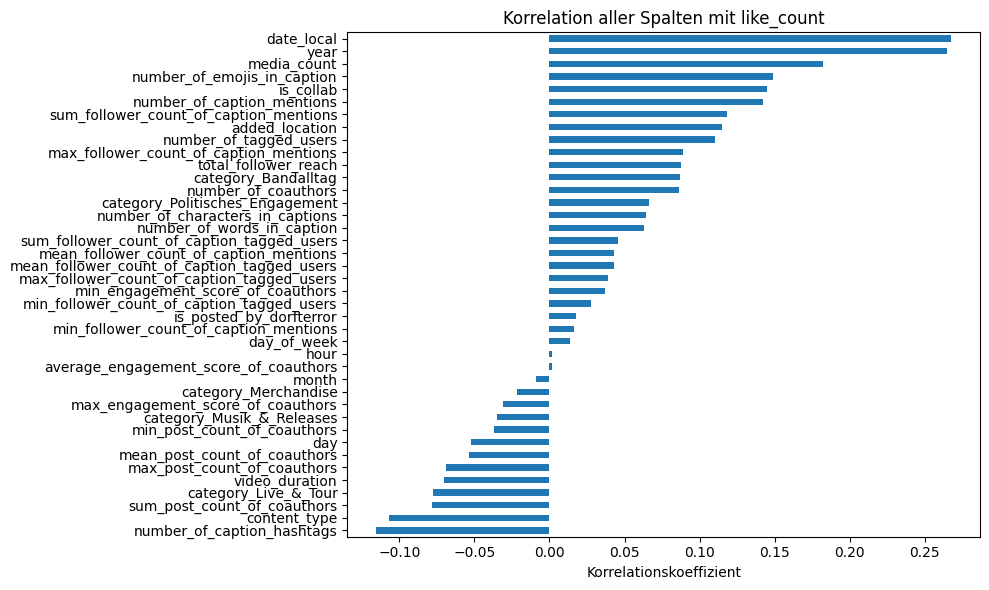

In [31]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path(".").resolve()

dorfterror_fe = pd.read_parquet(
    root_path / "insta_analytics_notebooks" / "dorfterror_feature_engineered.parquet"
)

temp_df = dorfterror_fe.copy()

temp_df = temp_df.drop(columns=["follower_like_ratio"])
correlations = temp_df.corr()['like_count'].drop('like_count') 

correlation_df = pd.DataFrame({
    'Spalte': correlations.index,
    'Korrelation': correlations.values
}).sort_values('Korrelation', ascending=False, key=abs) 


plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh')
plt.title('Korrelation aller Spalten mit like_count')
plt.xlabel('Korrelationskoeffizient')
plt.tight_layout()
plt.show()